# 🏡 **CALIFORNIA HOUSE PRICING PREDICTION ML MODEL** 💰
**Project Overview -** This project implements a comprehensive machine learning pipeline to predict the median house value across California districts (derived from the 1990 U.S. Census). By leveraging Scikit-Learn and XGBoost, I developed a robust regression system that preprocesses geographic and demographic data to identify the primary drivers of real estate pricing.

**Note -** Refer `README.md` file in the repository for more information regarding this project.

In [1]:
# Step 1: Imports & Dataset Loading

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
# Step 2: Load Dataset & Create Income Categories (for Stratification)

housing = fetch_california_housing(as_frame=True)
df = housing.frame

# Create income category for stratified split
df["income_cat"] = pd.cut(
    df["MedInc"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

In [3]:
# Step 3: Stratified Train-Test Split

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df["income_cat"]):
    train_set = df.loc[train_idx]
    test_set = df.loc[test_idx]

# Drop stratification column
for s in (train_set, test_set):
    s.drop("income_cat", axis=1, inplace=True)

X_train = train_set.drop("MedHouseVal", axis=1)
y_train = train_set["MedHouseVal"]

X_test = test_set.drop("MedHouseVal", axis=1)
y_test = test_set["MedHouseVal"]

In [4]:
# Step 4: Preprocessing Pipelines

num_features = X_train.columns

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features)
])

In [5]:
# Step 5: Building Model Pipelines

models = {
    "LinearRegression": LinearRegression(),

    "DecisionTree": DecisionTreeRegressor(
        max_depth=12,
        min_samples_leaf=10,
        random_state=42
    ),

    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42
    ),

    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
}


Training LinearRegression...


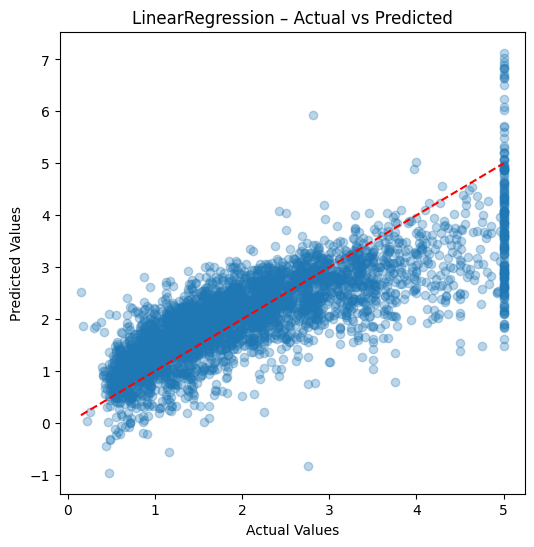


Training DecisionTree...


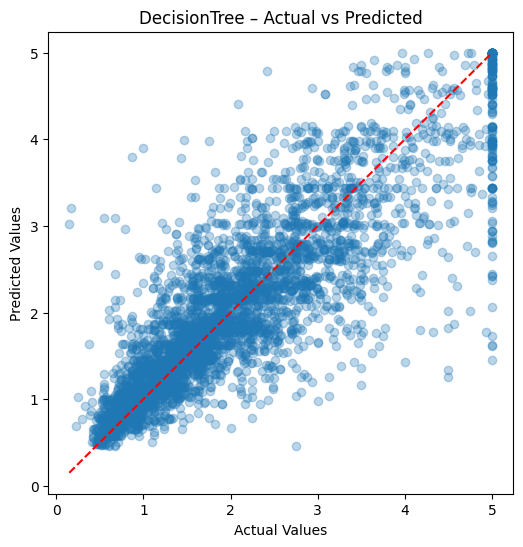


Training RandomForest...


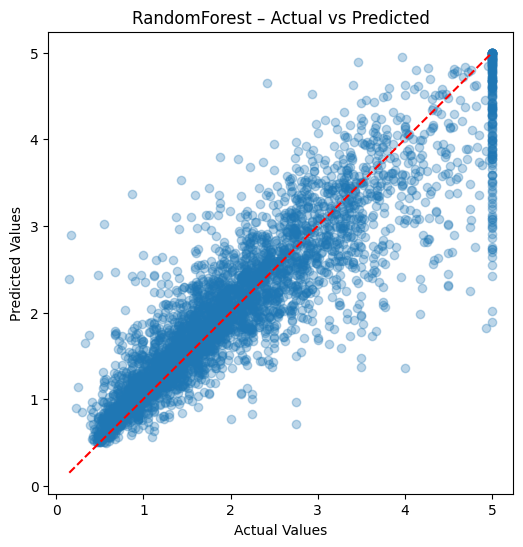


Training XGBoost...


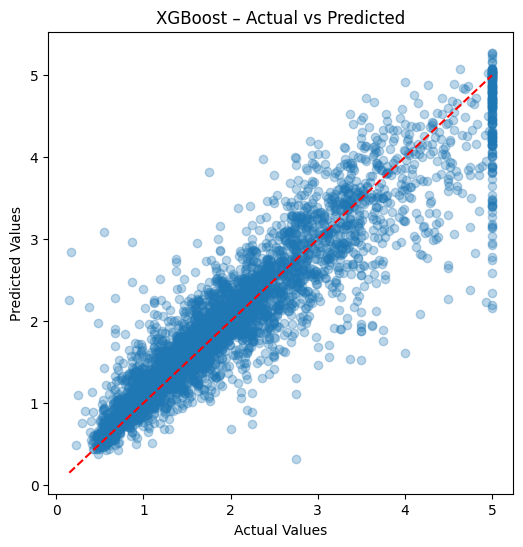

In [6]:
# Step 6: Training, Cross-Validation & Evaluation

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Cross-Validation (RMSE)
    cv_rmse = -1 * cross_val_score(
        pipeline, X_train, y_train,
        scoring="neg_root_mean_squared_error",
        cv=5
    ).mean()

    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Metrics
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Save model
    joblib.dump(pipeline, f"{name}_model.pkl")

    # Store results
    results[name] = {
        "CV_RMSE": cv_rmse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "y_pred": y_pred
    }

    # Plot Actual vs Predicted
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             "r--")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} – Actual vs Predicted")
    plt.show()

In [7]:
# Step 7: Final Error Report (Markdown Ready)

for name, metrics in results.items():
    print(f"""
>## {name}
>- Cross-Validation RMSE: {metrics['CV_RMSE']:.4f}
>- Test RMSE: {metrics['RMSE']:.4f}
>- Mean Absolute Error (MAE): {metrics['MAE']:.4f}
>- R² Score: {metrics['R2']:.4f}
""")


>## LinearRegression
>- Cross-Validation RMSE: 0.7312
>- Test RMSE: 0.7120
>- Mean Absolute Error (MAE): 0.5260
>- R² Score: 0.6111


>## DecisionTree
>- Cross-Validation RMSE: 0.6247
>- Test RMSE: 0.6025
>- Mean Absolute Error (MAE): 0.4075
>- R² Score: 0.7215


>## RandomForest
>- Cross-Validation RMSE: 0.5196
>- Test RMSE: 0.4954
>- Mean Absolute Error (MAE): 0.3290
>- R² Score: 0.8117


>## XGBoost
>- Cross-Validation RMSE: 0.4622
>- Test RMSE: 0.4391
>- Mean Absolute Error (MAE): 0.2940
>- R² Score: 0.8521



# ⚖️ **ML Model Comparison (California Housing Dataset)**
> ## A) Linear Regression Model
>- Cross-Validation RMSE: 0.7312
>- Test RMSE: 0.7120
>- Mean Absolute Error (MAE): 0.5260
>- R² Score: 0.6111


> ## B) Decision Tree Model
>- Cross-Validation RMSE: 0.6247
>- Test RMSE: 0.6025
>- Mean Absolute Error (MAE): 0.4075
>- R² Score: 0.7215


> ## C) Random Forest Model
>- Cross-Validation RMSE: 0.5196
>- Test RMSE: 0.4954
>- Mean Absolute Error (MAE): 0.3290
>- R² Score: 0.8117


> ## D) XGBoost Model
>- Cross-Validation RMSE: 0.4622
>- Test RMSE: 0.4391
>- Mean Absolute Error (MAE): 0.2940
>- R² Score: 0.8521

# 🚀 **CONCLUSION**
The accuracy of the output results are considered good if:
- **RMSE** has a lower value,
- **MAE** has a lower value and,
- **R²** has a higher value.

Hence, the **XGBoost** model outperforms the other ML models with a lower RMSE and MAE and a higher R², indicating better predictive accuracy.

Each model's `.pkl` file is built using joblib and is attached in the repository for further modifications and deployment using Flask or Fast API. Though using `XGBoost_model.pkl` is recommended for higher accuracy.